Nama : Tiara Lailatul Nikmah  
User Name : Tiara Laila  
Email : tiaralaila21@gmail.com  
No Telepon : 089635924667  
Asal Kota : Juwana,Pati

In [1]:
import pandas as pd
df = pd.read_csv('SPAM text message.csv')

In [2]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# melakukan proses one-hot-encoding karena "label" berupa data kategorikal
category = pd.get_dummies(df.Category)
df_baru = pd.concat([df, category], axis=1)

In [4]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
 2   ham       5572 non-null   uint8 
 3   spam      5572 non-null   uint8 
dtypes: object(2), uint8(2)
memory usage: 98.1+ KB


In [5]:
# mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values
pesan = df_baru['Message'].values
label = df_baru[['ham', 'spam']].values
df_baru = df_baru.drop(columns='Category')
df_baru


,Message,ham,spam
0,"Go until jurong point, crazy.. Available only ...",1,0
1,Ok lar... Joking wif u oni...,1,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,0,1
3,U dun say so early hor... U c already then say...,1,0
4,"Nah I don't think he goes to usf, he lives aro...",1,0
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,0,1
5568,Will ü b going to esplanade fr home?,1,0
5569,"Pity, * was in mood for that. So...any other s...",1,0
5570,The guy did some bitching but I acted like i'd...,1,0


In [6]:
# bagi data untuk training dan data untuk testing
from sklearn.model_selection import train_test_split
pesan_latih, pesan_test, label_latih, label_test = train_test_split(pesan, label, test_size=0.2)


In [7]:
#  ubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(pesan_latih) 
tokenizer.fit_on_texts(pesan_test)


# mengonversi setiap sampel menjadi sequence 
sekuens_latih = tokenizer.texts_to_sequences(pesan_latih)
sekuens_test = tokenizer.texts_to_sequences(pesan_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [8]:
#  menggunakan layer Embedding dengan dimensi embedding sebesar 16
# dimensi dari input sebesar nilai num_words pada objek tokenizer

import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),              # hiden layer 1
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),               # hiden layer 2
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])


# panggil fungsi compile dan tentukan optimizer serta loss function
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          80000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         41472     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [9]:
# fungsi callback untuk menghentikan epoch apabila akurasi sudah mencapai 98%
class toCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.98 and logs.get('accuracy')==1.00):
      print("Proses Training Berhenti, Tingkat Akurasi Sudah Lebih Dari 98%")
      self.model.stop_training = True

callbacks= toCallback()

In [10]:
# mulai melatih model dengan memanggil fungsi fit()
num_epochs = 30
latih = model.fit(padded_latih, label_latih, epochs=num_epochs, batch_size=256,
                  validation_data=(padded_test, label_test), verbose=2, 
                  callbacks=[callbacks]) # memanggil fungsi callback

Epoch 1/30
18/18 - 33s - loss: 0.5186 - accuracy: 0.8313 - val_loss: 0.3996 - val_accuracy: 0.8700
Epoch 2/30
18/18 - 15s - loss: 0.3927 - accuracy: 0.8649 - val_loss: 0.3519 - val_accuracy: 0.8700
Epoch 3/30
18/18 - 15s - loss: 0.2822 - accuracy: 0.8649 - val_loss: 0.1872 - val_accuracy: 0.8700
Epoch 4/30
18/18 - 15s - loss: 0.1355 - accuracy: 0.9186 - val_loss: 0.1243 - val_accuracy: 0.9839
Epoch 5/30
18/18 - 16s - loss: 0.0335 - accuracy: 0.9933 - val_loss: 0.0835 - val_accuracy: 0.9857
Epoch 6/30
18/18 - 16s - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.0849 - val_accuracy: 0.9874
Epoch 7/30
18/18 - 15s - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.0881 - val_accuracy: 0.9874
Epoch 8/30
18/18 - 17s - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0727 - val_accuracy: 0.9857
Epoch 9/30
18/18 - 16s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0762 - val_accuracy: 0.9883
Epoch 10/30
18/18 - 15s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0816 - val_accuracy: 0.9883
Epoch 11/

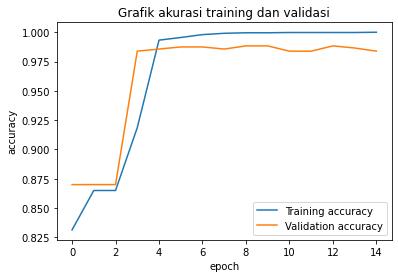

<Figure size 432x288 with 0 Axes>

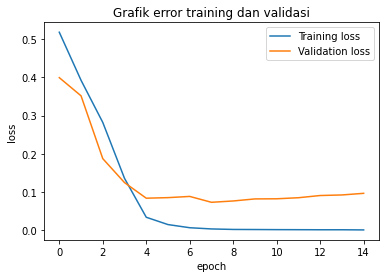

<Figure size 432x288 with 0 Axes>

In [11]:
# membuat grafik akurasi data training dan validasi
import matplotlib.pyplot as plt

akurasi = latih.history['accuracy']
val_akurasi = latih.history['val_accuracy']
loss = latih.history['loss']
val_loss = latih.history['val_loss']

epoch_range = range(len(akurasi))

plt.plot(epoch_range, akurasi, label='Training accuracy')
plt.plot(epoch_range, val_akurasi, label='Validation accuracy')
plt.title('Grafik akurasi training dan validasi')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epoch_range, loss, label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Grafik error training dan validasi')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc=0)
plt.figure()
plt.show()